# Categorizing Coding Languages with README Files
Mathias Boissevain | Stephen Kipkurui | Braeden Wright | Craig Calzado 

# Project Goal

**For this project we are building a model that can predict the main programming language of a repository, given the text of the README file. We will use 100 different README files from repositories available on GitHub, and use Natural Language Processing on the text within to build our model.  We will fisrt attempt to determine if the repo represents one of the top (3,5,?) coding languages used overall, then using a seperate model we will narrow down which language is most likely being used(all based on what is written in the README file)**

# Planning
* Setup repository environment (.gitignore, README.md)
* Make sure the .json/.csv file containing the dataset is accessible
* Import and test our acquire and wrangle functions



# Executive Summary
***We explored the data and discovered:***



***Recommandations:***



***Next Step:***
- Acquire a larger random sample of github repositories for increased accuracy on model
- Identify different features to further access README file(such as if there is a graphic in the README)
- 
--------------
## Import Menagerie

In [1]:
# Basics
import numpy as np
import pandas as pd
import nltk
import re
import os
import json

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Speciality
from typing import Dict, List, Optional, Union, cast
import requests
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer


# Custom
import base_acquire
import wrangle

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plotting defaults
plt.rc('figure', figsize=(12, 8))
plt.rc('font', size=16)

# Acquire the data

**We acquired the data from repositories found on GitHub, and pulled them into a dataframe using web scrapping and functions from our acquire.py file and saved the data in a .json file**

In [2]:
# Pull dataframe
if os.path.exists('data.json'):
    print('Reading data from json file...')
    df = pd.read_json('data.json')
else:
    print('Scrapping data from Github...')
    df = pd.DataFrame(base_acquire.scrape_github_data())
    # download cleaned data to a .json
    df.to_json('data.json')
    
df.head()

Reading data from json file...


,repo,language,readme_contents
0,ccxt/ccxt,JavaScript,# CCXT – CryptoCurrency eXchange Trading Libra...
1,openssl/openssl,C,Engines\n=======\n\nDeprecation Note\n--------...
2,HelloZeroNet/ZeroNet,JavaScript,# ZeroNet [![Build Status](https://travis-ci.o...
3,freqtrade/freqtrade,Python,# ![freqtrade](https://raw.githubusercontent.c...
4,amark/gun,JavaScript,"<p id=""readme""><a href=""https://gun.eco/""><img..."


In [3]:
# Clean the README text
df['clean_text'] = df['readme_contents'].apply(wrangle.clean).apply(' '.join)
df['language'] = df['language'].str.lower()

# Feature Engineer README length
df['text_length'] = df.clean_text.apply(len)
df.head()

,repo,language,readme_contents,clean_text,text_length
0,ccxt/ccxt,javascript,# CCXT – CryptoCurrency eXchange Trading Libra...,ccxt cryptocurrency exchange trading library b...,12619
1,openssl/openssl,c,Engines\n=======\n\nDeprecation Note\n--------...,engine deprecation note engine api introduced ...,10357
2,HelloZeroNet/ZeroNet,javascript,# ZeroNet [![Build Status](https://travis-ci.o...,zeronet build readmezhcnmd englishreadmemd bit...,1991
3,freqtrade/freqtrade,python,# ![freqtrade](https://raw.githubusercontent.c...,freqtrade coverage freqtrade free open source ...,5801
4,amark/gun,javascript,"<p id=""readme""><a href=""https://gun.eco/""><img...",p idreadmea width40 width50 alignright vspace2...,6672


# Data Wrangle

* Using publicly available repositories from Github, 
* Using function from wrangle.py, cleaned the data                     
* Download cleaned data to a .json

# Data Exploration 

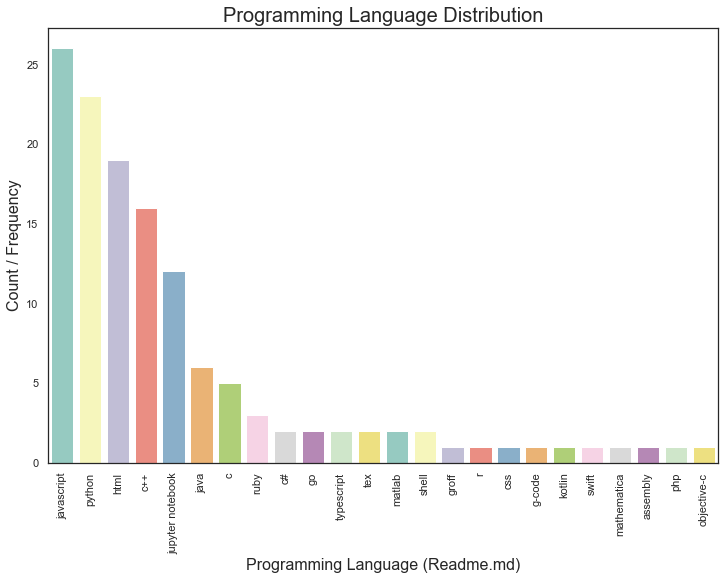

In [4]:
# Starting our exploration we quickly noticed a trend of a handful of programing languages dominating our data.
# As a result, we made the decision to focus on these main languages in an effort build a model more accurately discern between them

sns.set_theme(style="white")
ax = sns.countplot(x="language", data=df, palette="Set3",order = df['language'].value_counts().index)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Programming Language (Readme.md)', size = 16)
ax.set_ylabel('Count / Frequency', size = 16)
ax.set_title("Programming Language Distribution", size = 20)
plt.show()

### Initial Questions
- What are the most common words in READMEs?

- Does the length of the README vary by programming language?

- Do different programming languages use a different number of unique words?

- Are there any words that uniquely identify a programming language?
--------
--------
## What are the most common words in READMEs?

In [5]:
# Set up word counts dataframe
all_text = ' '.join(df.clean_text)
javascript_text = ' '.join(df[df.language == 'javascript'].clean_text)
python_text = ' '.join(df[df.language == 'python'].clean_text)
html_text = ' '.join(df[df.language == 'html'].clean_text)
cplusplus_text = ' '.join(df[df.language == 'c++'].clean_text)
java_text = ' '.join(df[df.language == 'java'].clean_text)

In [6]:
all_text = wrangle.clean(all_text)
javascript_text = wrangle.clean(javascript_text)
python_text = wrangle.clean(python_text)
html_text = wrangle.clean(html_text)
cplusplus_text = wrangle.clean(cplusplus_text)
java_text = wrangle.clean(java_text)

In [7]:
all_freq = pd.Series(str(all_text).split()).value_counts()
javascript_freq = pd.Series(str(javascript_text).split()).value_counts()
python_freq = pd.Series(str(python_text).split()).value_counts()
html_freq = pd.Series(str(html_text).split()).value_counts()
cplusplus_freq = pd.Series(str(cplusplus_text).split()).value_counts()
java_freq = pd.Series(str(java_text).split()).value_counts()

In [8]:
word_counts = pd.concat([all_freq, javascript_freq, python_freq, html_freq, cplusplus_freq, java_freq], sort=True, axis=1)
word_counts.columns = ['all', 'javascript', 'python', 'html', 'c++', 'java']
word_counts = word_counts.fillna(0).apply(lambda s: s.astype(int))

In [9]:
top_25 = word_counts.sort_values(by='all', ascending=False).head(25)
top_25

,all,javascript,python,html,c++,java
"'data',",623,73,63,266,31,18
"'version',",410,179,19,25,43,16
"'use',",401,91,61,28,52,14
"'run',",343,106,34,24,41,16
"'code',",333,61,37,44,70,11
"'project',",316,59,68,54,34,8
"'build',",309,65,11,5,87,12
"'using',",300,78,34,34,26,10
"'install',",295,85,68,15,58,4
"'file',",292,60,26,39,39,14


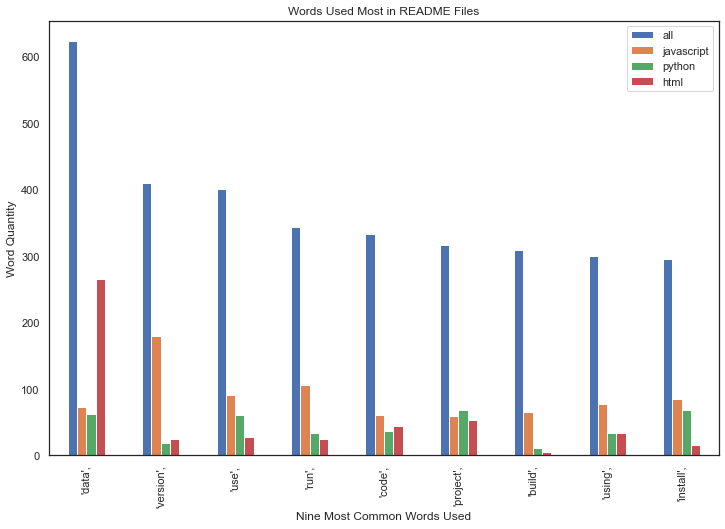

In [10]:
# Visualize word distribution
word_counts.sort_values(by='all', ascending=False)[['all', 'javascript', 'python', 'html']].head(9).plot.bar()
plt.title('Words Used Most in README Files')
plt.style.use('seaborn-whitegrid')
plt.xlabel('Nine Most Common Words Used')
plt.ylabel('Word Quantity')
plt.show()

**Takeaways:**
- While not common, there are two or 3 words that lean heavily towards one programing language over another. ('Data' for example makes the repo most likely HTML)
-----------
## Does the length of the README vary by programming language?

In [11]:
# Thankfully we've already feature engineeer a column containing the REAME length
# We can quickly look into this one
df.text_length.describe()

count      132.000000
mean      4198.568182
std       4869.862584
min         60.000000
25%       1246.500000
50%       2628.500000
75%       5543.000000
max      41580.000000
Name: text_length, dtype: float64

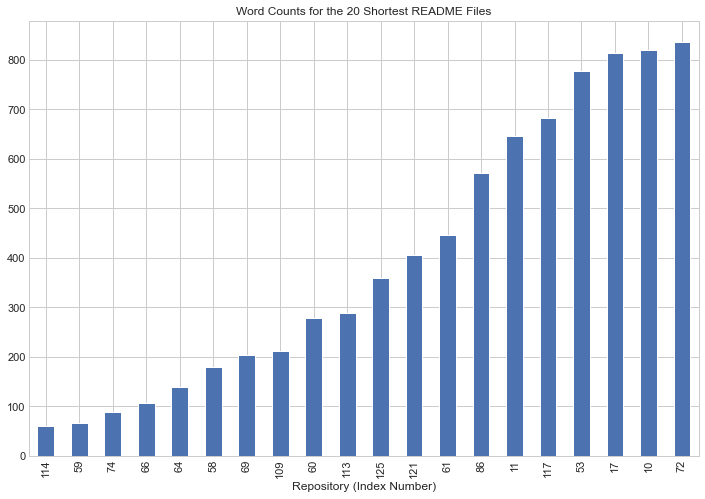

In [12]:
# Shortest 20 README(s)
df.clean_text.apply(len).sort_values().head(20).plot.bar(x=df.repo)
plt.title('Word Counts for the 20 Shortest README Files')
plt.xlabel('Repository (Index Number)')
plt.ylabel('')
plt.show()

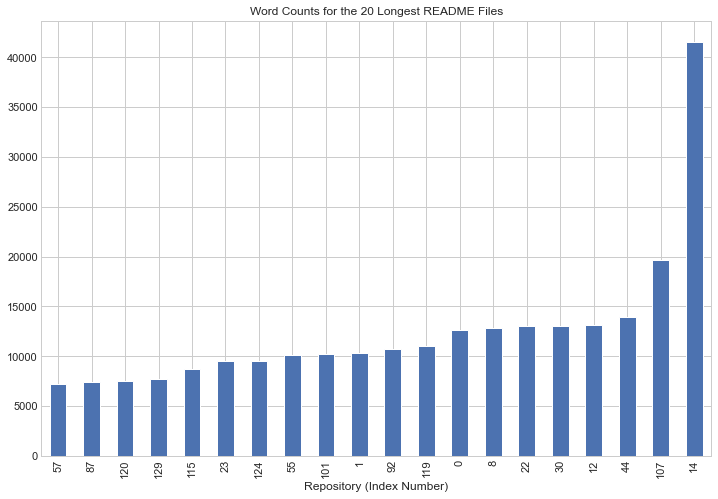

In [13]:
# Longest 20 README(s)
df.clean_text.apply(len).sort_values().tail(20).plot.bar()
plt.title('Word Counts for the 20 Longest README Files')
plt.xlabel('Repository (Index Number)')
plt.show()

**Takeaways:**
* Largest README sizes reach up to over 53,000 words but most of the larger README's average between 10,000 and 20,000
* Smallest README sizes a much shorter, with the bottom 8 being less than 300 words long
* The smaller README files average at about 600 words per file.
-----------
## Are there any words or bigrams that can uniquely identify one of our top languages?

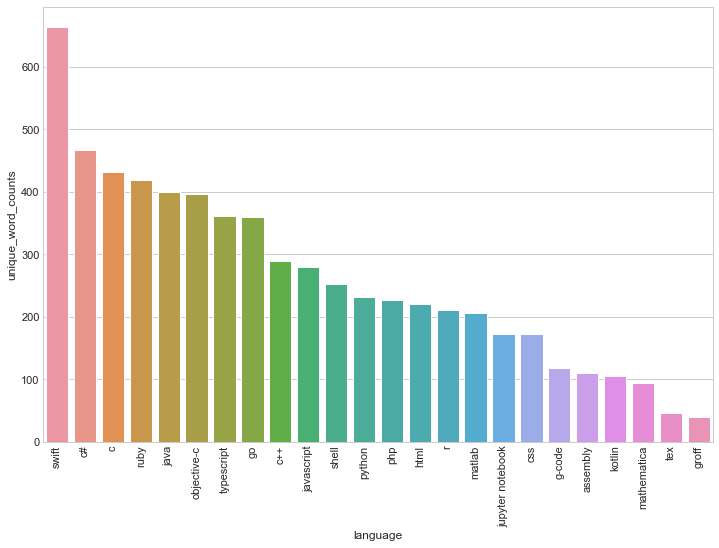

In [14]:
# Visual of the unique word counts
df['unique_word_counts'] = df.clean_text.apply(lambda x : len(set(x.split())))

unique_df = pd.DataFrame(df.groupby('language').unique_word_counts.mean().sort_values(ascending=False)).reset_index()
unique_df.head()

ax = sns.barplot(x='language',y='unique_word_counts',data=unique_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

**Takeaways:**
- With our current samples, our main coding language didnt have any words that automatically identify them as a specific language.
- There weren't any strong bigrams

-----------
## Are there any words that uniquely identify a programming language?

In [15]:
# We did a review of the words and could not find any word that fit specifically to one language.
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python,html,c++,java
"'data',",623,73,63,266,31,18
"'version',",410,179,19,25,43,16
"'use',",401,91,61,28,52,14
"'run',",343,106,34,24,41,16
"'code',",333,61,37,44,70,11
"'project',",316,59,68,54,34,8
"'build',",309,65,11,5,87,12
"'using',",300,78,34,34,26,10
"'install',",295,85,68,15,58,4
"'file',",292,60,26,39,39,14


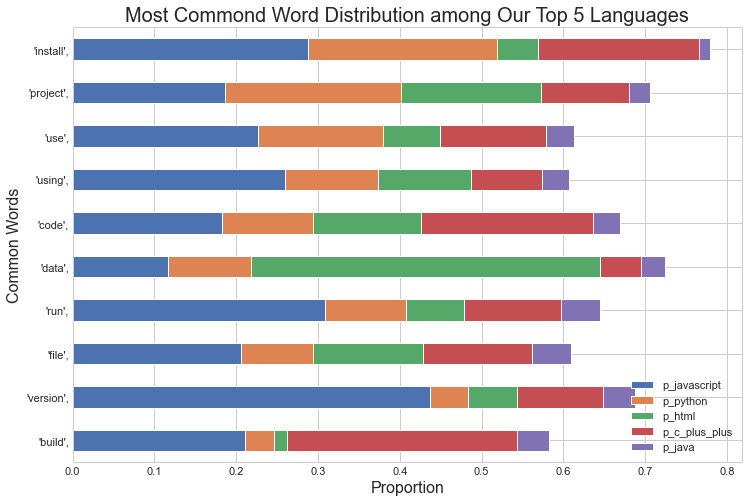

In [16]:
# Visualize of our search efforts
(word_counts
 .assign(p_javascript = word_counts.javascript / word_counts['all'],
         p_python = word_counts.python / word_counts['all'],
         p_html = word_counts.html / word_counts['all'],
         p_c_plus_plus = word_counts['c++']/ word_counts['all'],
         p_java = word_counts.java / word_counts['all']

        ).sort_values(by = 'all')
 [['p_javascript', 'p_python', 'p_html', 'p_c_plus_plus', 'p_java']]
 .tail(10)
 .sort_values('p_python')
 .plot.barh(stacked = True))

plt.title('Most Commond Word Distribution among Our Top 5 Languages', size = 20)
plt.ylabel('Common Words', size = 16)
plt.xlabel('Proportion', size = 16)
plt.show()

**Takeaways:**
* While there are certainly language that dominate the use of one word (such as 'data' being mostly in HTML), there are no taletell words that immediately give away what programming language the README is associated with.
-----------
# Modeling 

In [17]:
# DummyClassifier from sklearn is used to create a baseline accuracy.
from sklearn.dummy import DummyClassifier 
# TfidfVectorizer is used to create a sparce matrices of tf-idf scores to run through modeling
from sklearn.feature_extraction.text import TfidfVectorizer
# Import to split the data into train, test, split
from sklearn.model_selection import train_test_split
# Import to model the data
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Import to understand the data modeling scores
from sklearn.metrics import classification_report, accuracy_score
# Set Random State
rs = 1729

In [18]:
df.head()

,repo,language,readme_contents,clean_text,text_length,unique_word_counts
0,ccxt/ccxt,javascript,# CCXT – CryptoCurrency eXchange Trading Libra...,ccxt cryptocurrency exchange trading library b...,12619,624
1,openssl/openssl,c,Engines\n=======\n\nDeprecation Note\n--------...,engine deprecation note engine api introduced ...,10357,522
2,HelloZeroNet/ZeroNet,javascript,# ZeroNet [![Build Status](https://travis-ci.o...,zeronet build readmezhcnmd englishreadmemd bit...,1991,133
3,freqtrade/freqtrade,python,# ![freqtrade](https://raw.githubusercontent.c...,freqtrade coverage freqtrade free open source ...,5801,379
4,amark/gun,javascript,"<p id=""readme""><a href=""https://gun.eco/""><img...",p idreadmea width40 width50 alignright vspace2...,6672,549


In [19]:
# Create a list of top five languages by appearance in the dataset
top_five = ['javascript','python','html','c++','jupyter notebook']
# Create a new version of our df to transform for modeling
model_me = df.copy()
# Rename the languages that are not in the top 5 "not_top_five"
model_me['language'] = model_me.language.apply(lambda lang : lang if lang in top_five else "not_top_five")
# show the distribution
model_me.language.value_counts(normalize=True)

not_top_five        0.272727
javascript          0.196970
python              0.174242
html                0.143939
c++                 0.121212
jupyter notebook    0.090909
Name: language, dtype: float64

- Our Data was relabeled so that languages that were not in our top 5 were binned into a seperate category. We will be predicting if a README file represents one of the top five frequently used languages or is not in the top five.

In [20]:
# Setting a baseline of 'not_top_five'

# Here we create and fit the model
dummy = DummyClassifier(strategy='most_frequent', random_state = rs)
dummy.fit(model_me[model_me.columns[model_me.columns != 'language']], model_me.language)   

# Here we create our prediction
y_pred = dummy.predict(model_me[model_me.columns[model_me.columns != 'language']])

# Check report for current baseline accuracy:
print(classification_report(model_me.language, y_pred))

                  precision    recall  f1-score   support

             c++       0.00      0.00      0.00        16
            html       0.00      0.00      0.00        19
      javascript       0.00      0.00      0.00        26
jupyter notebook       0.00      0.00      0.00        12
    not_top_five       0.27      1.00      0.43        36
          python       0.00      0.00      0.00        23

        accuracy                           0.27       132
       macro avg       0.05      0.17      0.07       132
    weighted avg       0.07      0.27      0.12       132



- For our baseline score 'not_top_five' was used at it is the most frequent occurance in our df.

In [21]:
# Create the tf-idf model
tfidf = TfidfVectorizer()
# Fit the model and create the X, y variables for modeling
X = tfidf.fit_transform(model_me.clean_text)
y = model_me.language 
# Split the data into train (71%), validate (18.5%), test (10.5%) split
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, stratify=y, test_size=.1, random_state = rs)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, stratify=y_train_validate, test_size=.2, random_state = rs)

- Term Frequency - Inverse Document Frequency or TF-IDF is the measure we will be using to run our models
    - TF is how often the word appears in a document
    - IDF is a measure of how many documents the word appears in
    - TF-IDF is a combination of these two measures and gives us a good picture of the words present in each document and their weight
- Variables are created with X being our TF-IDF scores and y being our target variable
- The data is split for modeling with 71 % for Train, 18.5 for Validate, and 10.5 for Test.

In [22]:
# Create Result Dataframes to store actual and predictive scores from the models
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [23]:
# Create and fit each model
lm = LogisticRegression(multi_class='multinomial',random_state=rs).fit(X_train, y_train)
dtc = DecisionTreeClassifier(max_depth=4, random_state=rs).fit(X_train, y_train)
rf = RandomForestClassifier(min_samples_leaf=3,max_depth=4, random_state=rs).fit(X_train,y_train)
knn = KNeighborsClassifier().fit(X_train,y_train)

- The models we used inherently support multiclass classification problems

In [24]:
# Store the train predictions in our result df
train['lm_predicted'] = lm.predict(X_train)
train['dtc_predicted'] = dtc.predict(X_train)
train['rf_predicted'] = rf.predict(X_train)
train['knn_predicted'] = knn.predict(X_train)

In [25]:
# Show the scores for train on the logistic regression model
print('Logistic Regression')
print(classification_report(train.actual, train.lm_predicted))

Logistic Regression
                  precision    recall  f1-score   support

             c++       1.00      1.00      1.00        11
            html       1.00      1.00      1.00        14
      javascript       1.00      1.00      1.00        18
jupyter notebook       1.00      0.89      0.94         9
    not_top_five       0.96      1.00      0.98        25
          python       1.00      1.00      1.00        17

        accuracy                           0.99        94
       macro avg       0.99      0.98      0.99        94
    weighted avg       0.99      0.99      0.99        94



In [26]:
# Show the scores for train on the Decision Tree model
print('Decision Tree')
print(classification_report(train.actual, train.dtc_predicted))

Decision Tree
                  precision    recall  f1-score   support

             c++       0.00      0.00      0.00        11
            html       1.00      0.57      0.73        14
      javascript       1.00      0.44      0.62        18
jupyter notebook       1.00      0.78      0.88         9
    not_top_five       0.59      0.68      0.63        25
          python       0.40      1.00      0.58        17

        accuracy                           0.61        94
       macro avg       0.67      0.58      0.57        94
    weighted avg       0.67      0.61      0.58        94



In [27]:
# Show the scores for train on the Random Forest Model
print('Random Forest')
print(classification_report(train.actual, train.rf_predicted))

Random Forest
                  precision    recall  f1-score   support

             c++       1.00      0.64      0.78        11
            html       0.92      0.86      0.89        14
      javascript       1.00      0.72      0.84        18
jupyter notebook       1.00      0.44      0.62         9
    not_top_five       0.60      1.00      0.75        25
          python       0.93      0.82      0.87        17

        accuracy                           0.80        94
       macro avg       0.91      0.75      0.79        94
    weighted avg       0.87      0.80      0.80        94



In [28]:
# Show the scores for train on the KNN Model
print('KNN')
print(classification_report(train.actual, train.knn_predicted))

KNN
                  precision    recall  f1-score   support

             c++       0.58      0.64      0.61        11
            html       0.62      0.93      0.74        14
      javascript       0.60      0.67      0.63        18
jupyter notebook       0.89      0.89      0.89         9
    not_top_five       0.52      0.44      0.48        25
          python       0.64      0.41      0.50        17

        accuracy                           0.62        94
       macro avg       0.64      0.66      0.64        94
    weighted avg       0.61      0.62      0.61        94



- In our train phase logistic regression performed far better than our other models

In [29]:
# Assign the validate predictions to the results df
validate['lm_predicted'] = lm.predict(X_validate)
validate['dtc_predicted'] = dtc.predict(X_validate)
validate['rf_predicted'] = rf.predict(X_validate)
validate['knn_predicted'] = knn.predict(X_validate)

In [30]:
# Show the scores for validate on the Logistic Regression Model
print('Validate on Logistic Regression')
print(classification_report(validate.actual, validate.lm_predicted))

Validate on Logistic Regression
                  precision    recall  f1-score   support

             c++       0.00      0.00      0.00         3
            html       1.00      0.33      0.50         3
      javascript       1.00      0.20      0.33         5
jupyter notebook       0.00      0.00      0.00         2
    not_top_five       0.32      1.00      0.48         7
          python       0.00      0.00      0.00         4

        accuracy                           0.38        24
       macro avg       0.39      0.26      0.22        24
    weighted avg       0.43      0.38      0.27        24



In [31]:
# Show the scores for validate on the Decision Tree Model
print('Validate on Decision Tree')
print(classification_report(validate.actual, validate.dtc_predicted))

Validate on Decision Tree
                  precision    recall  f1-score   support

             c++       0.00      0.00      0.00         3
            html       0.00      0.00      0.00         3
      javascript       0.67      0.40      0.50         5
jupyter notebook       0.67      1.00      0.80         2
    not_top_five       0.25      0.14      0.18         7
          python       0.21      0.75      0.33         4

        accuracy                           0.33        24
       macro avg       0.30      0.38      0.30        24
    weighted avg       0.30      0.33      0.28        24



In [32]:
# Show the scores for validate on the Random Forest Model
print('Validate on Random Forest')
print(classification_report(validate.actual, validate.rf_predicted))

Validate on Random Forest
                  precision    recall  f1-score   support

             c++       0.00      0.00      0.00         3
            html       1.00      0.33      0.50         3
      javascript       1.00      0.20      0.33         5
jupyter notebook       0.00      0.00      0.00         2
    not_top_five       0.33      1.00      0.50         7
          python       0.00      0.00      0.00         4

        accuracy                           0.38        24
       macro avg       0.39      0.26      0.22        24
    weighted avg       0.43      0.38      0.28        24



In [33]:
#Show the scores for validate on the KNN Model
print('Validate on KNN')
print(classification_report(validate.actual, validate.knn_predicted))

Validate on KNN
                  precision    recall  f1-score   support

             c++       0.25      0.33      0.29         3
            html       0.50      1.00      0.67         3
      javascript       0.50      0.80      0.62         5
jupyter notebook       1.00      1.00      1.00         2
    not_top_five       0.25      0.14      0.18         7
          python       0.00      0.00      0.00         4

        accuracy                           0.46        24
       macro avg       0.42      0.55      0.46        24
    weighted avg       0.35      0.46      0.38        24



- Through Validate our Logistic Regression model shows overfitting, our decision tree model looks like it stays the most consistent.

In [34]:
# Assign the predicitons to the results df
test['dtc_predicted'] = dtc.predict(X_test)

In [35]:
# Show the scores for test on the KNN Model
print('Test on Decision Tree Model')
print(classification_report(test.actual, test.dtc_predicted))

Test on Decision Tree Model
                  precision    recall  f1-score   support

             c++       0.00      0.00      0.00         2
            html       1.00      1.00      1.00         2
      javascript       0.00      0.00      0.00         3
jupyter notebook       0.00      0.00      0.00         1
    not_top_five       0.50      0.50      0.50         4
          python       0.00      0.00      0.00         2

        accuracy                           0.29        14
       macro avg       0.25      0.25      0.25        14
    weighted avg       0.29      0.29      0.29        14



- The Decision Tree showed the the best performance consistently staying well above baseline. In Test the Decision Tree performed 17 % above baseline

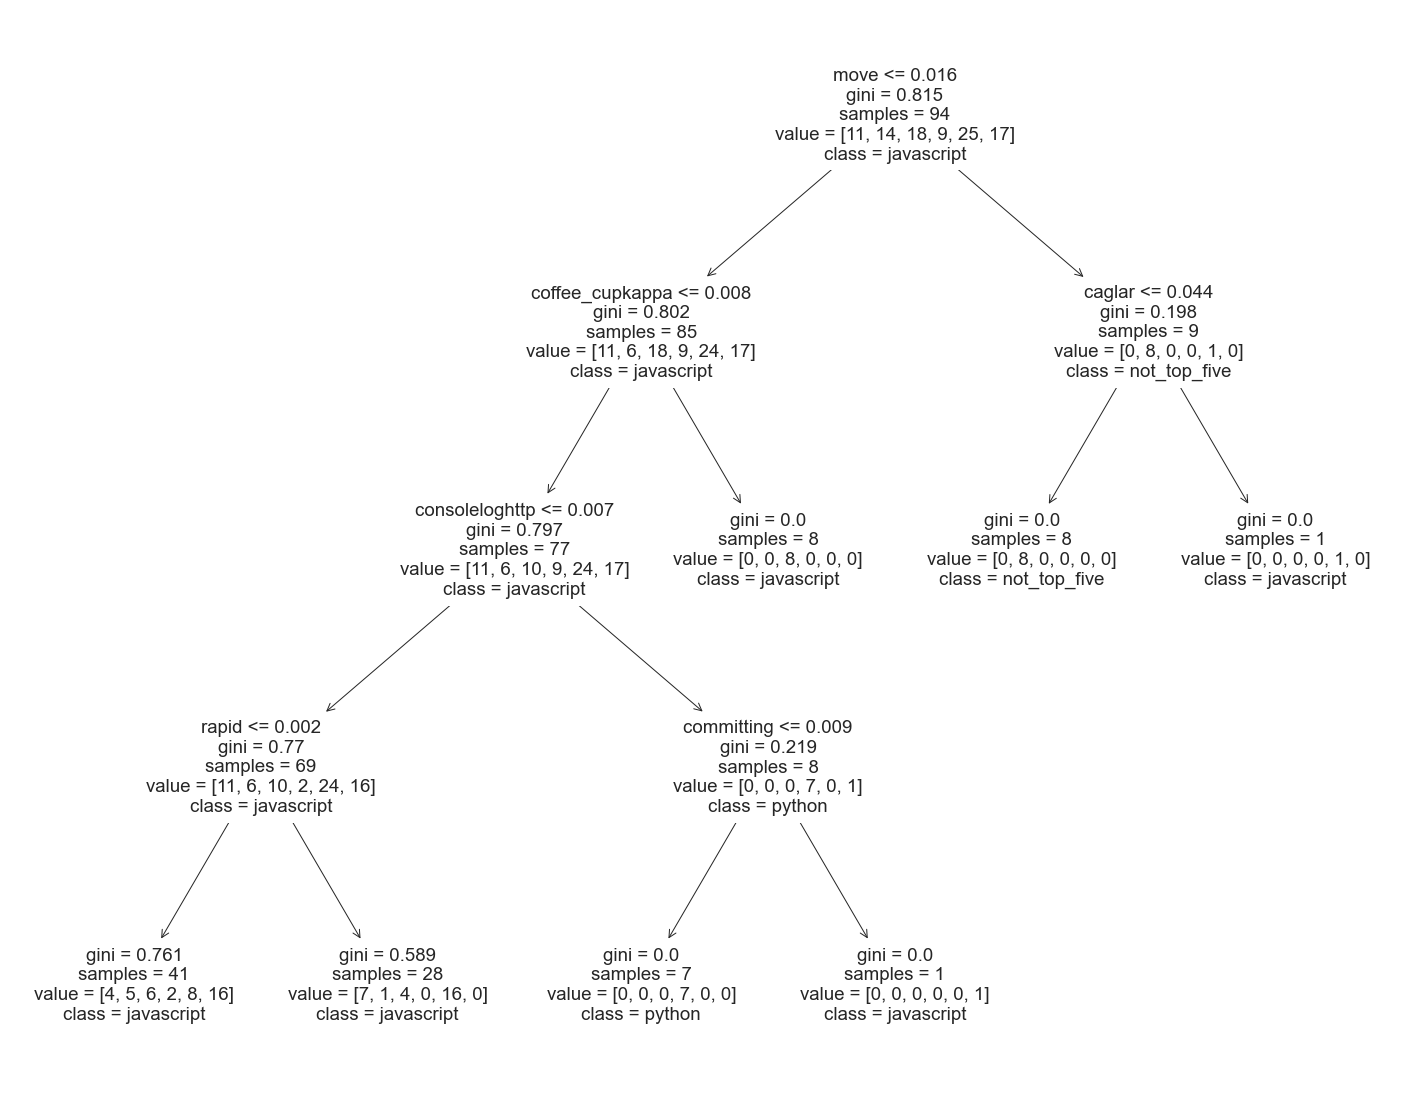

In [36]:
tree_var = pd.DataFrame(X[0].T.todense(), index= tfidf.get_feature_names(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
plt.figure(figsize=(25,20))
plot_tree(dtc, feature_names = tree_var.index, class_names=y)
plt.show()

# Conclusion
-----------------------------

# Key Findings From Exploration and Modeling

# Recommendation

* tbd
* tbd
* tbd

# Next Step

* Acquire a larger random sample of github repositories for increased accuracy on model


* Identify different features to further access README file
    * graphic or visualization in the README
    * Coding example in the README

